## 1: Exploratory Data Analysis and Preprocessing

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("haoboxu/amazon-reviews-for-sentiment-analysis")

print("Path to dataset files:", path)

100%|██████████| 282M/282M [00:03<00:00, 90.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/haoboxu/amazon-reviews-for-sentiment-analysis/versions/1


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

In [ ]:
import torch
from tqdm.notebook import tqdm

In [ ]:
df1 = pd.read_csv(path+'/fashion/fashion/13_17.csv',index_col=0).sample(250000)
df2 = pd.read_csv(path+'/game/game/13_17.csv',index_col=0).sample(250000)
df3 = pd.read_csv(path+'/software/software/13_17.csv',index_col=0).sample(250000)

df = pd.concat([df1, df2, df3])
df = df.dropna()

In [ ]:
df.shape

(749961, 3)

## 2: Training/Validation Split

In [ ]:
y = np.zeros((df.shape[0], 3))
for i in range(3):
    y[:,i] = df['overall'].values == (i-1)


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=45)

index, _ = rus.fit_resample(np.arange(y.shape[0]).reshape((-1,1)), y)
index = index.reshape((-1,))
df = df.iloc[index,:]
y = y[index]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df['reviewText'].values, y, train_size=0.35, test_size=0.2, random_state=257)

# 3. Loading Tokenizer and Encoding our Data

In [ ]:
from transformers import BertTokenizerFast
from torch.utils.data import TensorDataset

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    # pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    X_val.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    # pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    max_length=256,
    return_tensors='pt'
)



In [ ]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_val)

In [ ]:
dataset_train = TensorDataset(input_ids_train,
                              attention_masks_train,
                              labels_train)

dataset_val = TensorDataset(input_ids_val,
                            attention_masks_val,
                           labels_val)

In [ ]:
len(dataset_train)

69186

In [ ]:
dataset_val.tensors

(tensor([[ 101, 2069, 1037,  ...,    0,    0,    0],
         [ 101, 2147, 6581,  ...,    0,    0,    0],
         [ 101, 1045, 4149,  ...,    0,    0,    0],
         ...,
         [ 101, 6581, 2614,  ...,    0,    0,    0],
         [ 101, 2025, 3243,  ...,    0,    0,    0],
         [ 101, 1045, 2031,  ...,    0,    0,    0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([[1., 0., 0.],
         [0., 0., 1.],
         [0., 1., 0.],
         ...,
         [0., 0., 1.],
         [0., 1., 0.],
         [1., 0., 0.]], dtype=torch.float64))

# 4. Setting up BERT Pretrained Model

In [ ]:
from transformers import BertForSequenceClassification

In [ ]:
model = BertForSequenceClassification.from_pretrained(
                                      'bert-base-uncased',
                                      output_attentions = False,
                                      output_hidden_states = False, num_labels=3
                                     )

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 5. Creating Data Loaders

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [ ]:
batch_size = 64

train_data_loader = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

val_data_loader = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=32
)

# 6. Setting Up Optimizer and Scheduler

In [ ]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

In [ ]:
optimizer = AdamW(
    model.parameters(),
    lr = 1e-5,
    eps = 1e-8
)

In [ ]:
epochs = 3

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps = len(val_data_loader)*epochs
)

# 7. Defining our Performance Metrics

In [ ]:
def accuracy_func(preds, labels):
    zeros = np.zeros(labels.shape)
    zeros[np.arange(zeros.shape[0]),preds.argmax(axis=1)] = 1
    return accuracy_score(labels, zeros)

# 8. Creating our Training Loop

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [ ]:
def evaluate(val_data_loader):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in tqdm(val_data_loader):

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(val_data_loader)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0

    progress_bar = tqdm(train_data_loader,
                        desc=f'Epoch {epoch}',
                        leave=False,
                        disable=False)

    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})



    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(train_data_loader)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(val_data_loader)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Validation accuracy: {accuracy_func(predictions, true_vals)}')


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1082 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.37752974387139554


  0%|          | 0/1236 [00:00<?, ?it/s]

Validation loss: 0.33226594261037756
Validation accuracy: 0.7769627681100769


Epoch 2:   0%|          | 0/1082 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.3120928445481471


  0%|          | 0/1236 [00:00<?, ?it/s]

Validation loss: 0.32742552633984606
Validation accuracy: 0.7817179279643869


Epoch 3:   0%|          | 0/1082 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.2870565414165719


  0%|          | 0/1236 [00:00<?, ?it/s]

Validation loss: 0.32775907472859755
Validation accuracy: 0.7852084176446783


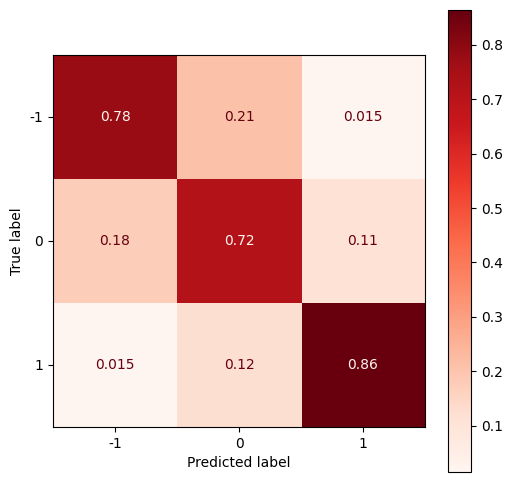

In [ ]:
zeros = np.zeros(predictions.shape)
zeros[np.arange(zeros.shape[0]),predictions.argmax(axis=1)] = 1

fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay.from_predictions(
        np.argmax(true_vals,axis=1)-1,
        np.argmax(zeros,axis=1)-1,
        cmap="Reds",
        normalize='true',
        ax=ax
    )

In [ ]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = BertTokenizerFast.from_pretrained(
                        'bert-base-uncased',
                        do_lower_case=True
                    )
        self.classifier = model

    def forward(self, text):
        encoded_data = self.tokenizer(
            text,
            add_special_tokens=True,
            return_attention_mask=True,
            padding='max_length',
            truncation=True,
            max_length=256,
            return_tensors='pt'
        )
        classes = self.classifier(
            **encoded_data
        )
        return classes["logits"]

my_model = NeuralNetwork().to('cpu')

In [ ]:
torch.save(my_model, '/content/tokenizer_classifier_entire.pt')
torch.save(model, '/content/classifier_entire.pt')
torch.save(model.state_dict(), '/content/classifier_state_dict.pt')

In [ ]:
this_model = torch.load('/content/tokenizer_classifier_entire.pt', weights_only=False)
this_model.eval()
this_model(['I love this app and tenis without balls', 'We will destroy the world and three chocolates'])